In [123]:
import pandas as pd
import numpy as np

import torch
from tqdm import tqdm
# from tf2crf import CRF

# from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from skmultilearn.problem_transform import LabelPowerset
# from sklearn.multioutput import ClassifierChain

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, hamming_loss, f1_score
from sklearn.preprocessing import LabelEncoder

# from imblearn.over_sampling import SMOTE

from keras import layers
import keras
from keras.utils import to_categorical
from keras_preprocessing import sequence
from keras_preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

import seaborn as sns
# import xgboost as xgb
from sklearn.linear_model import LogisticRegression
# from skmultilearn.problem_transform import BinaryRelevance

from transformers import BertTokenizer, BertModel

from nltk.tokenize import word_tokenize
import os

import matplotlib.pyplot as plt

In [124]:
# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.13.0


In [258]:
data_path = os.path.join('data')
train_name = 'train_cleaned_2.csv'
train_cleaned = pd.read_csv(os.path.join(data_path, train_name), delimiter=',').dropna()

In [259]:
train_cleaned.head()

,text,label
0,kunjung prabowo resmi serah proyek bantu bersi...,Sumber Daya Alam
1,anies tepuk tangan riah rektor wajib kuliah ko...,Politik
2,bener dukung goblok dukung ridwan kamil skema ...,Demografi
3,anies sikap kritis kerja prabowo anggap engga ...,Politik
4,anies baswedan harap polri pegang sumpah milu,Politik


In [260]:
class_map={'Demografi':0, 'Ekonomi':1, 'Geografi':2, 'Ideologi':3, 'Pertahanan dan Keamanan':4,
          'Politik':5, 'Sosial Budaya':6, 'Sumber Daya Alam':7}

# Show number of different classes
n_classes = len(class_map)
print('Number of different classes: {}'.format(n_classes))

# Mapping the class names
train_cleaned['label'] = train_cleaned['label'].map(class_map)

Number of different classes: 8


In [261]:
train_cleaned[train_cleaned['label'] == 5].shape

(2969, 2)

In [129]:
# # jumlah_hapus = 2500
# # hapus_idx = train_cleaned[train_cleaned['label'] == 5].sample(n=jumlah_hapus, random_state=42).index
# # train_cleaned = train_cleaned.drop(hapus_idx)


# max_jumlah = 300

# # Mengiterasi setiap kategori di label
# for label in train_cleaned['label'].unique():
#     jumlah_data = train_cleaned[train_cleaned['label'] == label].shape[0]
#     if jumlah_data > max_jumlah:
#         hapus_idx = train_cleaned[train_cleaned['label'] == label].sample(n=jumlah_data - max_jumlah, random_state=42).index
#         train_cleaned = train_cleaned.drop(hapus_idx)

# # Memverifikasi hasil
# for label in train_cleaned['label'].unique():
#     print(f"Label {label} memiliki {train_cleaned[train_cleaned['label'] == label].shape[0]} data.")

<Axes: xlabel='label'>

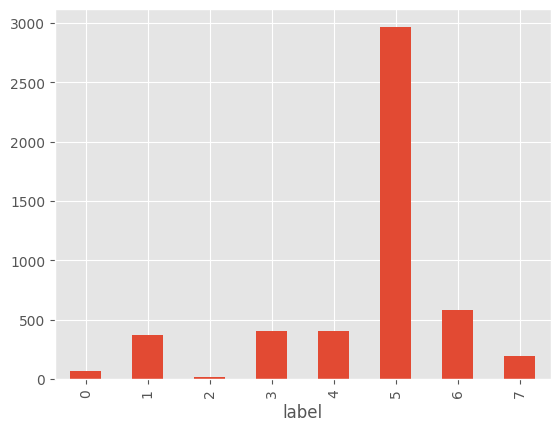

In [262]:
train_cleaned.groupby('label').size().plot(kind='bar')

In [263]:
dummy_columns = pd.get_dummies(train_cleaned['label'])
train_cleaned = pd.concat([train_cleaned, dummy_columns], axis=1).drop('label', axis=1).dropna()
train_cleaned.head()

,text,0,1,2,3,4,5,6,7
0,kunjung prabowo resmi serah proyek bantu bersi...,False,False,False,False,False,False,False,True
1,anies tepuk tangan riah rektor wajib kuliah ko...,False,False,False,False,False,True,False,False
2,bener dukung goblok dukung ridwan kamil skema ...,True,False,False,False,False,False,False,False
3,anies sikap kritis kerja prabowo anggap engga ...,False,False,False,False,False,True,False,False
4,anies baswedan harap polri pegang sumpah milu,False,False,False,False,False,True,False,False


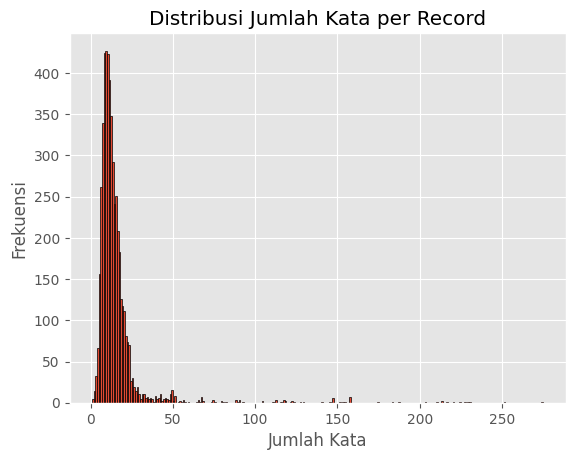

In [264]:
def count_words(text):
    return len(word_tokenize(text))

# Menghitung jumlah kata untuk setiap record
word_counts = [count_words(record) for record in train_cleaned['text']]

# Menampilkan histogram
plt.hist(word_counts, bins=range(1, max(word_counts) + 2), edgecolor='black')
plt.title('Distribusi Jumlah Kata per Record')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

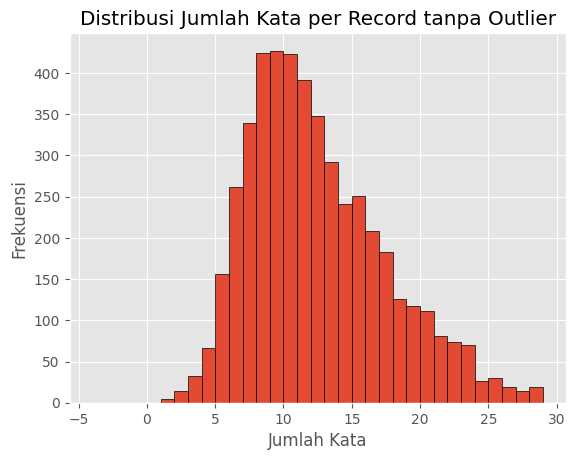

(4750, 9)


In [265]:
train_cleaned['word_count'] = train_cleaned['text'].apply(count_words)

# Menghitung Q1, Q3, dan IQR
Q1 = train_cleaned['word_count'].quantile(0.25)
Q3 = train_cleaned['word_count'].quantile(0.75)
IQR = Q3 - Q1

# Mendefinisikan batas bawah dan batas atas untuk outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menghapus outlier
train_filtered = train_cleaned[(train_cleaned['word_count'] >= lower_bound) & (train_cleaned['word_count'] <= upper_bound)]

# Menampilkan histogram tanpa outlier
plt.hist(train_filtered['word_count'], bins=range(int(lower_bound), int(upper_bound) + 2), edgecolor='black')
plt.title('Distribusi Jumlah Kata per Record tanpa Outlier')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()
train_filtered = train_filtered.drop(columns=['word_count'], axis=1)
print(train_filtered.shape)

In [266]:
X = train_filtered['text'].values
y = train_filtered.iloc[:,1:].values
print(X.shape, y.shape)
indices = np.arange(X.shape[0])

# Split the data along with the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, indices, test_size=0.2, random_state=1, stratify=y
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4750,) (4750, 8)
(3800,) (3800, 8) (950,) (950, 8)


In [267]:
y_train_single = np.argmax(y_train, axis=1)
y_test_single = np.argmax(y_test, axis=1)

class_distribution_train = np.unique(y_train_single, return_counts=True)
class_distribution_test = np.unique(y_test_single, return_counts=True)
print(f'Sebaran Label Data Train: {class_distribution_train}')
print(f'Sebaran Label Data Test: {class_distribution_test}')


Sebaran Label Data Train: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([  46,  277,   14,  301,  302, 2291,  425,  144]))
Sebaran Label Data Test: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 12,  69,   4,  75,  75, 573, 106,  36]))


In [136]:
def baseline_ml_preprocessing(X_train,X_test):
    word_vectorizer = TfidfVectorizer(
        strip_accents='unicode',     
        analyzer='word',
        max_features=3000,        
        token_pattern=r'\w{1,}',    
        ngram_range=(1, 4),         
        # stop_words='indonesian',
        sublinear_tf=True)

    word_vectorizer.fit(X_train)
    ml_X_train = word_vectorizer.transform(X_train)
    ml_X_test = word_vectorizer.transform(X_test)
    return ml_X_train, ml_X_test

def Sequential_Preprocessing(X_train, X_test, y_train, y_test,max_seq_len):
    tokenizer = Tokenizer(num_words=40000,oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    X_train = torch.from_numpy(pad_sequences(X_train, maxlen=max_seq_len))
    X_test = torch.from_numpy(pad_sequences(X_test, maxlen=max_seq_len))

    y_train = torch.from_numpy(y_train)
    y_test = torch.from_numpy(y_test)

    return tokenizer, X_train, y_train, X_test, y_test


def get_bert_embedding_matrix(tokenizer):
    bert_model = BertModel.from_pretrained('indobenchmark/indobert-base-p1')
    bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
    vocab_size = len(tokenizer.index_word)+1
    bert_embedding_matrix = torch.zeros(vocab_size, 768)


    tokens_tensor=[]
    for i in tqdm(range(1, vocab_size)):
        word = tokenizer.index_word[i]
        tokens = bert_tokenizer.encode(word,add_special_tokens=False)[0]
        tokens_tensor.append(tokens)
    batch_size = 256
    vocab_batches = [tokens_tensor[i:i+batch_size] for i in range(0, len(tokens_tensor), batch_size)]

    with torch.no_grad():
      bert_embeddings = []
      for i in tqdm(range(len(vocab_batches))):
        batch = vocab_batches[i]
        inputs = {
        'input_ids': torch.tensor([batch]),
        'attention_mask': torch.ones(len(batch)).unsqueeze(0)
        }
        outputs = bert_model(**inputs)
        batch_embeddings = outputs[0][0]
        bert_embeddings.append(batch_embeddings)
        
    bert_embedding_matrix = torch.cat(bert_embeddings, dim=0)
    return bert_embedding_matrix


In [137]:
ml_X_train, ml_X_test = baseline_ml_preprocessing(X_train,X_test)
print("X_train shape for baseline models:",ml_X_train.shape)
print("X_test shape for baseline models:",ml_X_test.shape)

X_train shape for baseline models: (3800, 3000)
X_test shape for baseline models: (950, 3000)


In [138]:
scores_df = pd.DataFrame(columns=['model_name','micro_avg_f1_score','hamming_loss','accuracy'])

In [139]:
class HierarchicalSVM:
    def __init__(self):
        self.classifiers = {}#Dictionary to store the classifiers for each label

    def train(self, X_train, Y_train):
        num_labels = Y_train.shape[1]
        # Train the classifiers for each label
        for label_idx in range(num_labels):
            label = str(label_idx)
            Y_label = Y_train[:, label_idx]
            classifier = svm.SVC(kernel='linear')
            classifier.fit(X_train, Y_label)
            self.classifiers[label] = classifier

    def predict(self, X_test):
        num_labels = len(self.classifiers)
        num_samples = X_test.shape[0]
        predictions = np.zeros((num_samples, num_labels))
        for label_idx, classifier in self.classifiers.items():
            label_predictions = classifier.predict(X_test)
            predictions[:, int(label_idx)] = label_predictions
        return predictions

In [140]:
model = HierarchicalSVM()
model.train(ml_X_train, y_train)
y_pred = model.predict(ml_X_test)
print(classification_report(y_pred,y_test))
accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy Test: {accuracy}')
y_pred_t = model.predict(ml_X_train)
accuracy_t = accuracy_score(y_pred_t, y_train)
print(f'Accuracy Train: {accuracy_t}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.61      0.91      0.73        46
           2       0.00      0.00      0.00         0
           3       0.39      0.97      0.55        30
           4       0.56      0.84      0.67        50
           5       0.87      0.78      0.82       640
           6       0.37      0.87      0.52        45
           7       0.22      1.00      0.36         8

   micro avg       0.69      0.81      0.75       819
   macro avg       0.38      0.67      0.46       819
weighted avg       0.79      0.81      0.78       819
 samples avg       0.69      0.69      0.69       819

Accuracy Test: 0.6894736842105263
Accuracy Train: 0.7907894736842105


In [268]:
max_seq_len = 100
tokenizer, X_train, y_train, X_test, y_test = Sequential_Preprocessing(X_train, X_test, y_train, y_test,max_seq_len)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([3800, 100]) torch.Size([950, 100]) torch.Size([3800, 8]) torch.Size([950, 8])


In [142]:
# y_train_single = np.argmax(y_train, axis=1)
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled_single = rus.fit_resample(X_train, y_train_single)
# y_resampled = to_categorical(y_resampled_single, num_classes=8)

In [143]:
# y_train_single = np.argmax(y_train, axis=1)
# smote = SMOTE(random_state=777, k_neighbors=5)
# X_smote, y_smote_single = smote.fit_resample(X_train, y_train_single)
# y_smote = to_categorical(y_smote_single, num_classes=8)

In [144]:
# unique_classes, counts = np.unique(y_smote_single, return_counts=True)

# # Plot the distribution
# plt.figure(figsize=(10, 6))
# plt.bar(unique_classes, counts, color='blue')
# plt.xlabel('Class')
# plt.ylabel('Frequency')
# plt.title('Distribution of Classes')
# plt.xticks(unique_classes) 
# plt.grid(axis='y')

# # Display the plot
# plt.show()

In [145]:
# print("Shapes after SMOTE resampling:")
# print(X_smote.shape, y_smote.shape)

In [269]:
bert_embeddding_matrix = get_bert_embedding_matrix(tokenizer)
print(bert_embeddding_matrix.shape)

100%|██████████| 22/22 [00:03<00:00,  6.69it/s]

torch.Size([5610, 768])


In [147]:
# #Checking GPU for tensorflow
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.compat.v1.keras.backend.set_session(sess)
# print("GPU is Available? =>",tf.test.is_gpu_available())

In [270]:
VOCAB_SIZE = len(tokenizer.index_word)+1
bert_embd_mat= np.array(bert_embeddding_matrix.to('cpu').detach().numpy())
bert_embd_mat = np.vstack((np.zeros((1, bert_embd_mat.shape[1])), bert_embd_mat))

In [271]:
# Class weights
y_train_single = np.stack(y).argmax(axis=1)
classes = np.unique(y_train_single)
weights = compute_class_weight('balanced', classes=classes, y=y_train_single)
class_weights = {k: v for k, v in zip(classes, weights)}
print('Class weights:', class_weights)

Class weights: {0: 10.237068965517242, 1: 1.7160404624277457, 2: 32.986111111111114, 3: 1.579122340425532, 4: 1.5749336870026525, 5: 0.20731494413407822, 6: 1.1181732580037664, 7: 3.298611111111111}


In [150]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='accuracy',  
    mode='max',          
    patience=0,          
    verbose=1,           
    baseline=0.98,       
    restore_best_weights=True  
)

In [151]:
# inp = Input(shape=(max_seq_len,))
# x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
# x = tf.keras.layers.Conv1D(filters=256, 
#                                    kernel_size=4,
#                                    activation='relu', 
#                                    kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(units=256, activation='relu',
#                             kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x_out = tf.keras.layers.Dense(8, activation='sigmoid')(x)
# model = tf.keras.models.Model(inputs=inp, outputs=x_out)

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # y_train_single = np.argmax(y_train, axis=1)
# history = model.fit(np.asarray(X_train), np.asarray(y_train), 
#                     batch_size=32, 
#                     epochs=20, 
#                     validation_split=0.2,
#                     class_weight=class_weights
#                     )
# class_weight=class_weights
# history = model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=32, epochs=16)
# y_pred = model.predict(np.asarray(X_test),batch_size=32, verbose=1)
# y_pred= np.where(y_pred > 0.5, 1, 0)

# accuracy = accuracy_score(y_pred, y_test)
# print(f'Accuracy: {accuracy}')

In [152]:
print("=====================Bert BiLSTM===========================")
inp = Input(shape=(max_seq_len,))
x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
# x = TimeDistributed(Dense(50, activation="relu"))(x)
# x = GlobalMaxPool1D()(x)
x = Dropout(0.4)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
# x = Dropout(0.1)(x)
# x = Dense(20, activation="gelu")(x)
# x = Dropout(0.1)(x)
x = Dense(8, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

# class_distribution = torch.sum(y_train, dim=0).float()
# total_samples = torch.sum(class_distribution)
# class_weights = total_samples / (len(class_distribution) * class_distribution)
# class_weights_np = class_weights.numpy()
# class_weight_dict = {i: class_weights_np[i] for i in range(len(class_weights_np))}

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
y_train_single = np.argmax(y_train, axis=1)

# Fit the model with early stopping
history = model.fit(
    np.asarray(X_train), np.asarray(y_train), 
    batch_size=32, 
    epochs=20, 
    validation_split=0.2,
    class_weight=class_weights,
    # callbacks=[early_stopping]  # Add the early stopping callback
)
# class_weight=class_weights
# history = model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=32, epochs=16)
y_pred = model.predict(np.asarray(X_test),batch_size=32, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

=====================Bert BiLSTM===========================
Epoch 1/20
95/95 [==============================] - 39s 391ms/step - loss: 0.4015 - accuracy: 0.1046 - val_loss: 0.4103 - val_accuracy: 0.0526
Epoch 2/20
95/95 [==============================] - 45s 470ms/step - loss: 0.3695 - accuracy: 0.1888 - val_loss: 0.3765 - val_accuracy: 0.5039
Epoch 3/20
95/95 [==============================] - 44s 460ms/step - loss: 0.3448 - accuracy: 0.2803 - val_loss: 0.3947 - val_accuracy: 0.1632
Epoch 4/20
95/95 [==============================] - 44s 466ms/step - loss: 0.3203 - accuracy: 0.2819 - val_loss: 0.3601 - val_accuracy: 0.4684
Epoch 5/20
95/95 [==============================] - 44s 462ms/step - loss: 0.2854 - accuracy: 0.3776 - val_loss: 0.3591 - val_accuracy: 0.2671
Epoch 6/20
95/95 [==============================] - 43s 453ms/step - loss: 0.2668 - accuracy: 0.3845 - val_loss: 0.3268 - val_accuracy: 0.5092
Epoch 7/20
95/95 [==============================] - 42s 445ms/step - loss: 0.2368 

In [153]:
y_pred = model.predict(np.asarray(X_test),batch_size=32, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

y_pred_t = model.predict(np.asarray(X_train),batch_size=32, verbose=1)
y_pred_t= np.where(y_pred_t > 0.5, 1, 0)

accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy Data Test: {accuracy}')

accuracy = accuracy_score(y_pred_t, y_train)
print(f'Accuracy Data Train: {accuracy}')

119/119 [==============================] - 8s 70ms/step
Accuracy Data Test: 0.6294736842105263
Accuracy Data Train: 0.863421052631579


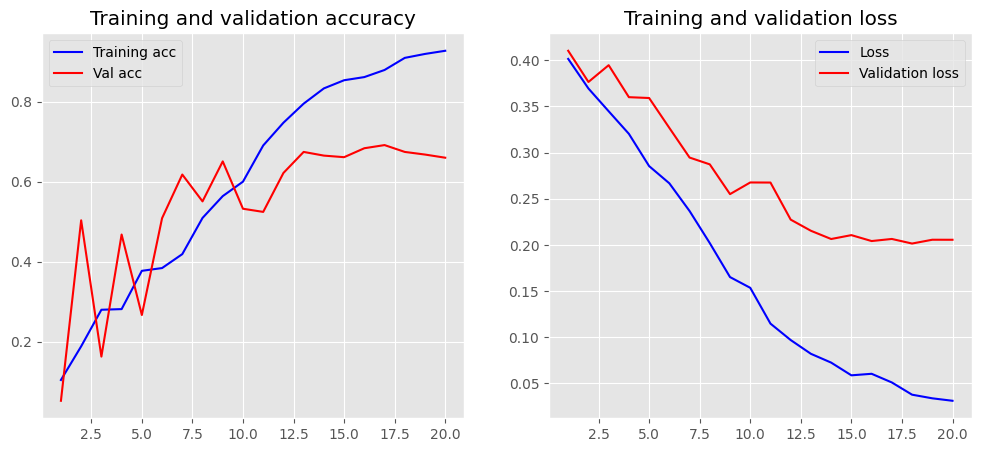

In [154]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Val acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x,loss, 'b', label='Loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [155]:
y_pred_single = np.argmax(y_pred, axis=1)
y_test_single = np.argmax(y_test, axis=1)

bert_cnn = pd.DataFrame({
    "text": X[test_indices],  
    "y_true": y_test_single,
    "y_pred": y_pred_single
})

# print(bert_cnn)
csv_file = "pred/bert-bilstm.xlsx"
bert_cnn.to_excel(os.path.join(data_path, csv_file), index=False)
print("Write CSV Done.")

Write CSV Done.


Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.33      0.07        12
           1       0.67      0.67      0.67        69
           2       0.00      0.00      0.00         4
           3       0.56      0.48      0.52        75
           4       0.72      0.65      0.69        75
           5       0.80      0.71      0.75       573
           6       0.54      0.47      0.51       106
           7       0.42      0.44      0.43        36

    accuracy                           0.64       950
   macro avg       0.47      0.47      0.45       950
weighted avg       0.71      0.64      0.67       950



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

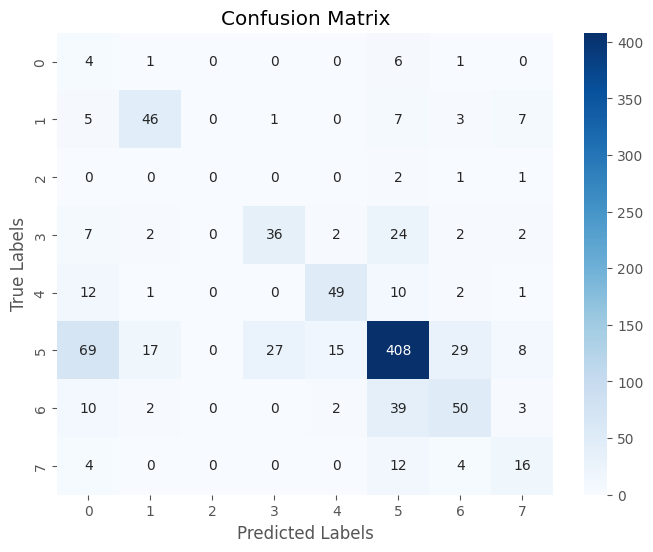

In [156]:
def evaluate_classification(data_true, data_predicted):
    # Print classification report
    report = classification_report(data_true, data_predicted)
    print("Classification Report:")
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(data_true, data_predicted)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
evaluate_classification(y_test_single, y_pred_single)

In [235]:
print("=====================Bert CNN===========================")
inp = Input(shape=(max_seq_len,))

x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = layers.Conv1D(filters = 32, kernel_size=5,activation='relu', padding='same',)(x)
x = GlobalMaxPool1D()(x)
# x = MaxPooling1D(pool_size=2)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(np.asarray(X_train),np.asarray(y_train),batch_size=64, epochs=15, validation_split=0.2)
y_pred = model.predict(np.asarray(X_test),batch_size=64, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

# arr={'model_name':'CNN_bert','micro_avg_f1_score':f1_score(y_test, y_pred, average="micro"),'hamming_loss':hamming_loss(y_test, y_pred),'accuracy':accuracy_score(y_test,y_pred)}
# scores_df = scores_df.append(arr,ignore_index=True)
# print(scores_df)
print(classification_report(y_pred,y_test))
accuracy = accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')


=====================Bert CNN===========================
Epoch 1/15
48/48 [==============================] - 3s 45ms/step - loss: 0.4357 - accuracy: 0.4454 - val_loss: 0.2633 - val_accuracy: 0.6197
Epoch 2/15
48/48 [==============================] - 2s 41ms/step - loss: 0.2744 - accuracy: 0.6030 - val_loss: 0.2224 - val_accuracy: 0.6605
Epoch 3/15
48/48 [==============================] - 2s 41ms/step - loss: 0.2444 - accuracy: 0.6263 - val_loss: 0.2068 - val_accuracy: 0.7171
Epoch 4/15
48/48 [==============================] - 2s 40ms/step - loss: 0.2016 - accuracy: 0.7072 - val_loss: 0.1794 - val_accuracy: 0.7434
Epoch 5/15
48/48 [==============================] - 2s 41ms/step - loss: 0.1640 - accuracy: 0.7701 - val_loss: 0.1674 - val_accuracy: 0.7553
Epoch 6/15
48/48 [==============================] - 2s 41ms/step - loss: 0.1305 - accuracy: 0.8214 - val_loss: 0.1796 - val_accuracy: 0.7355
Epoch 7/15
48/48 [==============================] - 2s 41ms/step - loss: 0.1053 - accuracy: 0.859

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


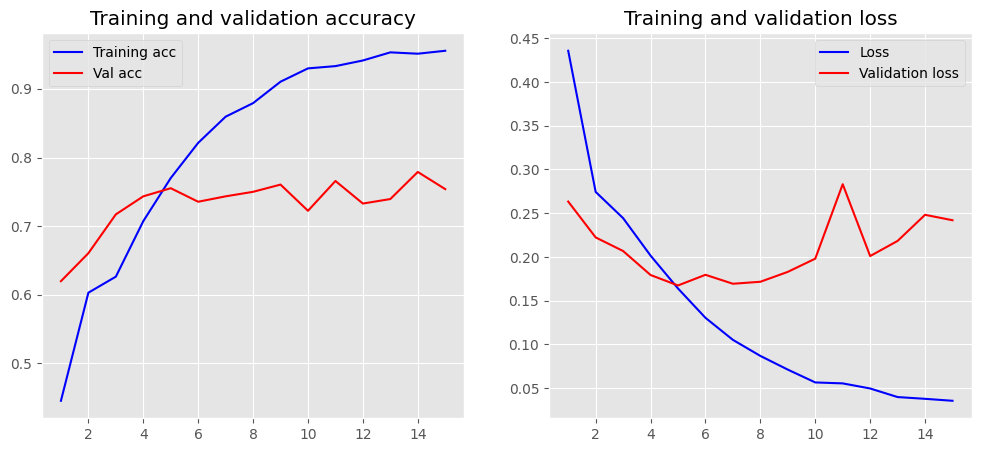

In [236]:
plot_history(history)

In [237]:
y_pred_single = np.argmax(y_pred, axis=1)
y_test_single = np.argmax(y_test, axis=1)

bert_cnn = pd.DataFrame({
    "text": X[test_indices],  
    "y_true": y_test_single,
    "y_pred": y_pred_single
})

# print(bert_cnn)
csv_file = "pred/bert-cnn.xlsx"
bert_cnn.to_excel(os.path.join(data_path, csv_file), index=False)
print("Write CSV Done.")

Write CSV Done.


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.80      0.52      0.63        69
           2       0.00      0.00      0.00         4
           3       0.80      0.44      0.57        75
           4       0.78      0.43      0.55        75
           5       0.77      0.89      0.83       573
           6       0.58      0.42      0.49       106
           7       0.62      0.28      0.38        36

    accuracy                           0.70       950
   macro avg       0.55      0.37      0.43       950
weighted avg       0.74      0.70      0.70       950



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

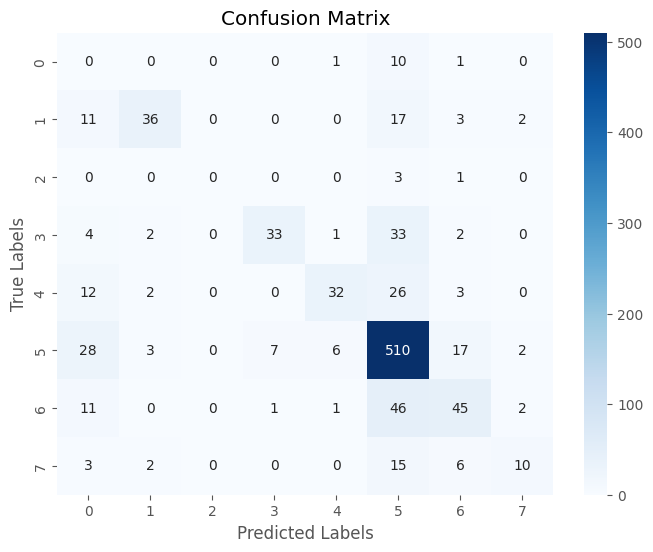

In [238]:
evaluate_classification(y_test_single, y_pred_single)

In [272]:
print("=====================Bert CNN-BiLSTM===========================")

inp = Input(shape=(max_seq_len,))

x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(100))(x)
x = Dropout(0.1)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

=====================Bert CNN-BiLSTM===========================
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_19 (Embedding)    (None, 100, 768)          4309248   
                                                                 
 conv1d_14 (Conv1D)          (None, 100, 32)           73760     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 bidirectional_13 (Bidirect  (None, 200)               106400    
 ional)                                                          
                                                            

In [273]:
history = model.fit(np.asarray(X_train),np.asarray(y_train), batch_size=8, epochs=10, validation_split=0.2)

Epoch 1/10
380/380 [==============================] - 10s 22ms/step - loss: 0.2809 - accuracy: 0.5717 - val_loss: 0.2491 - val_accuracy: 0.6197
Epoch 2/10
380/380 [==============================] - 8s 21ms/step - loss: 0.2366 - accuracy: 0.6197 - val_loss: 0.2116 - val_accuracy: 0.6724
Epoch 3/10
380/380 [==============================] - 8s 21ms/step - loss: 0.1896 - accuracy: 0.7092 - val_loss: 0.1940 - val_accuracy: 0.7171
Epoch 4/10
380/380 [==============================] - 8s 21ms/step - loss: 0.1458 - accuracy: 0.7957 - val_loss: 0.1860 - val_accuracy: 0.7276
Epoch 5/10
380/380 [==============================] - 8s 21ms/step - loss: 0.1101 - accuracy: 0.8474 - val_loss: 0.2010 - val_accuracy: 0.7342
Epoch 6/10
380/380 [==============================] - 8s 21ms/step - loss: 0.0839 - accuracy: 0.8918 - val_loss: 0.2062 - val_accuracy: 0.6882
Epoch 7/10
380/380 [==============================] - 8s 21ms/step - loss: 0.0693 - accuracy: 0.9115 - val_loss: 0.2185 - val_accuracy: 0.693

In [274]:
y_pred = model.predict(np.asarray(X_test),batch_size=8, verbose=1)
y_pred= np.where(y_pred > 0.5, 1, 0)

y_pred_single = np.argmax(y_pred, axis=1)
y_test_single = np.argmax(y_test, axis=1)

bert_cnn = pd.DataFrame({
    "text": X[test_indices],  
    "y_true": y_test_single,
    "y_pred": y_pred_single
})

# print(bert_cnn)
csv_file = "pred/bert-cnnbilstm.xlsx"
bert_cnn.to_excel(os.path.join(data_path, csv_file), index=False)
print("Write CSV Done.")

119/119 [==============================] - 1s 4ms/step
Write CSV Done.


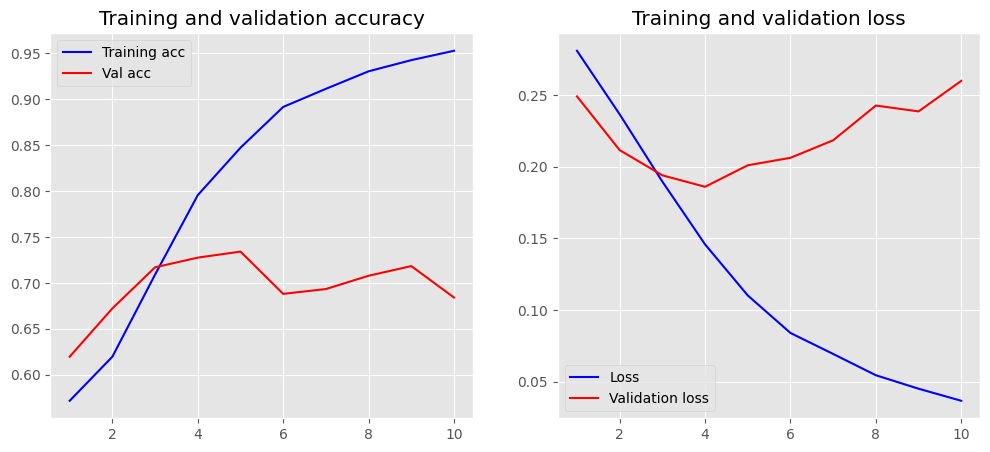

In [275]:
plot_history(history)

Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.42      0.07        12
           1       0.78      0.62      0.69        69
           2       0.00      0.00      0.00         4
           3       0.65      0.44      0.52        75
           4       0.82      0.44      0.57        75
           5       0.82      0.74      0.78       573
           6       0.46      0.45      0.45       106
           7       0.32      0.42      0.36        36

    accuracy                           0.63       950
   macro avg       0.49      0.44      0.43       950
weighted avg       0.73      0.63      0.67       950



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

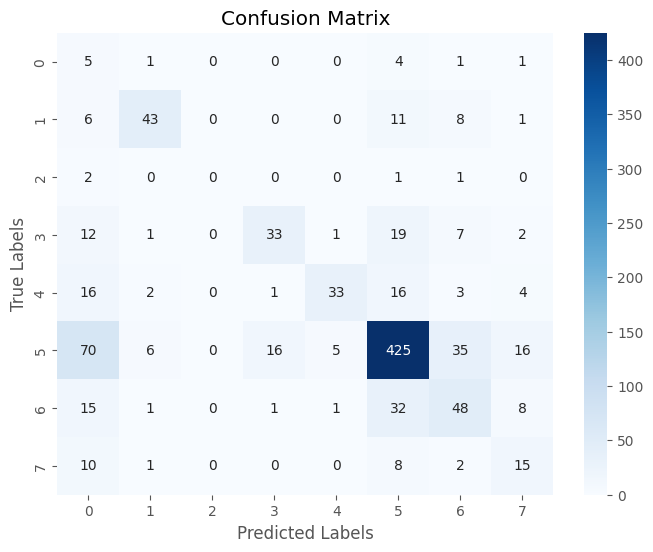

In [276]:
evaluate_classification(y_test_single, y_pred_single)

In [171]:
# inp = Input(shape=(max_seq_len,))

# x = Embedding(VOCAB_SIZE, 768, weights=[bert_embd_mat])(inp)
# x = Bidirectional(LSTM(units=50, return_sequences=True,
#                            recurrent_dropout=0.1))(x)  # variational biLSTM
# x = TimeDistributed(Dense(50, activation="relu"))(x)  # a dense layer as suggested by neuralNer
# crf = CRF(8+1)  # CRF layer, n_tags+1(PAD)
# out = crf(x)  # output

# model = Model(inp, out)
# model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()